# Applied CNN: Object Detection and YOLO in Action

## Object Detection

In the real world, an image can have multiple objects, our previous CNN model can only detect one object. In this section, we will learn how to detect multiple objects in an image.

![Image Classification vs Object Detection Example](https://littleml.files.wordpress.com/2022/06/screen-shot-2022-06-05-at-11.41.49-am.png)

[Image source](https://blog.bigml.com/2022/06/09/democratizing-object-detection/)

Object detection involves identifying and locating objects of interest within an image or a video. Above, in the left image, truck and car are identified, which is image classification. The image on the right illustrates object detection by surrounding the members of each class — cars and trucks — with a bounding box and showing the correct labels.

### Object localization

The bounding box is called object localization. We already learn about the image classification task where an algorithm looks a picture and gives an output saying this is a car. The problem of classification with localization is not only do you have to label this as, say, a car but the algorithm also is responsible for put a bounding box or drawing a red rectangle around the position of the car in the image, where the term localization refers to figuring out where in the picture is the car you detected.

Let's try the following image:

![cars](https://storage.googleapis.com/rg-ai-bootcamp/cnn/cars.jpeg)


To add bounding box, we can use the following CLI command (don't worry, we will learn how to do it in Python later):

In [ ]:
!yolo predict model=yolov8s.pt source="./assets/cars.jpeg"

Voila! We have successfully added bounding boxes to the cars in the image.

![cars_with_bounding_box](https://storage.googleapis.com/rg-ai-bootcamp/cnn/cars-yolo.jpeg)

We can say here that the bounding box is basically a set of coordinates that forms around the object that identify closely with a label.

We also know that if we we define the model to be able to detect 10 classes, we'll have an output containing the 10 classes with percentage of each class.

If we add them up together, then, for object localization, the output will not only contain class probabilities for the detected objects but also bounding box coordinates that specify the location of each detected object within the image. This allows the model to not only classify objects into predefined classes but also localize and outline their positions using bounding boxes.

The question is how we do that ?

### Building Bounding Box

In the previous section, we have learned how to build a CNN model for image classification.

In the case of image classification, the model output is

$$
\hat{y} = \begin{bmatrix} p_1 \\ p_2 \\ p_3 \end{bmatrix}
$$

where $\hat{y}$ is the predicted class probabilities for the three classes. Then we can use the argmax function to get the class with the highest probability.

However, in the context of object detection, we need to add bounding box coordinates to the output. We need to add four more elements to the output vector to represent the bounding box coordinates.

$$
\hat{y} = \begin{bmatrix} x \\ y \\ w \\ h \\ p_1 \\ p_2 \\ p_3 \end{bmatrix}
$$

Where $x$ and $y$ are the coordinates of the center of the bounding box, $w$ and $h$ are the width and height of the bounding box

### Empty Bounding Box

But what if there is no object in the image?

To represent empty box, we can add a new output element to indicate the probability of the image containing an object.

$$
\hat{y} = \begin{bmatrix} confidence \\ x \\ y \\ w \\ h \\ p_1 \\ p_2 \\ p_3 \end{bmatrix}
$$

Where $confidence$ is the probability of the image containing an object.

Note that it differs from $p_1$, $p_2$, and $p_3$, which are the probabilities of the image containing a car, a truck, and a motorcycle, respectively.

Example:

$$
\hat{y} = \begin{bmatrix} 0.9 \\ 200 \\ 300 \\ 20 \\ 30 \\ 0.1 \\ 0.1 \\ 0.8 \end{bmatrix}
$$

It means that the model predict 0.9 probability that the image contains an object, and the object is a car with 0.1 probability, a truck with 0.1 probability, and a motorcycle with 0.8 probability. The bounding box is located at (200, 300) with width 20 and height 30.

Another example:

$$
\hat{y} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0.1 \\ 0.1 \\ 0.8 \end{bmatrix}
$$

The model predicts 0 probability that the image contains an object. We can forget the remaining elements because they are not relevant.

### Sliding Window

Now that we have found a way to define a bounding box in our model, next let's think about how we'll implement object detection.

From our own logic, once we define a bounding box, the easiest and fastest way to detect the object is to simply test the box on the image, much like how a convolution or pooling works in CNN, except we don't do any calculation, but we take the image inside the box and check if the object exists inside the box. Then move on to the next pixel. Let's call this a sliding window.

After 1 pass through the image and we did not find anything, we then change the size of the bounding box and try again. Rinse and repeat.

![Sliding Window](https://storage.googleapis.com/rg-ai-bootcamp/cnn/sliding-window.png)

[Image source](https://datahacker.rs/deep-learning-object-detection/)

The above algorithm surely is not efficient. But there is a way to make it more efficient.

Remember the convolution operation in CNN? It is basically a sliding window with a kernel. The kernel is a matrix of weights that we multiply with the image pixels. The kernel is then **moved** to the next pixel and the process is repeated.

It turns out that we can implement the sliding window algorithm using convolution. However, the detail is beyond the scope of this course.

## YOLO Algorithm

![Yolo animation](https://storage.googleapis.com/rg-ai-bootcamp/cnn/yolo5.gif)

[Image source](https://commons.wikimedia.org/wiki/File:Yolo5.gif)

YOLO, short for "You Only Look Once," is a popular object detection algorithm known for its efficiency and real-time performance. It excels at swiftly detecting and localizing objects within images or video frames, making it valuable for various applications, including autonomous driving, surveillance, and computer vision tasks. YOLO's fame stems from its unique approach of dividing images into grids and simultaneously predicting bounding boxes and class probabilities within each grid cell. This one-pass design makes it exceptionally fast and suitable for real-time tasks. While YOLO is versatile and widely used, it may not be ideal for scenarios involving small objects, extreme size variations, or very high localization precision requirements, and it typically demands substantial training data for optimal performance.


### How does Yolo works ?

Souce: [MLForNerds](https://github.com/MLForNerds/YOLO-OBJECT-DETECTION-TUTORIALS)

This is based on YOLOv1, the original YOLO paper.

#### Smaller Grid

![Yolo Step 1](https://storage.googleapis.com/rg-ai-bootcamp/cnn/yolo-step-1.png)

First the original image is divided into $ S x S $ grid cells of equal size. Each cell in the grid will predict the class of the object inside the cell, if there is one.

#### Bounding Box Definition

![Yolo Step 2](https://storage.googleapis.com/rg-ai-bootcamp/cnn/yolo-step-2.png)

Inside the cell, we will predict the bounding box coordinates. One cell predicts 2 bounding boxes. The bounding box is defined by the center of the box, width, and height.

So in the above picture, the red dot is the center of the red box, the blue dot is the center of the blue box

#### Bounding Box Encoding

The bounding box is encoded as follow:

$x$ and $y$ are calculated relative to the cell top-left corner (anchor) and normalized by the cell width and height.

$$
x = \frac{x_{center} - x_{anchor}}{cell\_width} \\
y = \frac{y_{center} - y_{anchor}}{cell\_height}
$$

and $w$ and $h$ are calculated relative to the whole image width and height.

$$
w = \frac{w_{box}}{image\_width} \\
h = \frac{h_{box}}{image\_height}
$$


#### Data representation

In previous section, we model the data as follow:

$$
\hat{y} = \begin{bmatrix} confidence \\ x \\ y \\ w \\ h \\ p_1 \\ p_2 \\ p_3 \end{bmatrix}
$$

In YOLO - since we have multiple grids - we model the data as follow:

$$
\hat{y} = \begin{bmatrix} confidence \\ x \\ y \\ w \\ h \\ confidence \\ x \\ y \\ w \\ h \\ ... \\ p_1 \\ p_2 \\ p_3 \end{bmatrix}
$$


So we repeat the confidence, x, y, w, and h for each grid.

![Yolo Step 3](https://storage.googleapis.com/rg-ai-bootcamp/cnn/yolo-step-3.png)


#### Combining the output

![Yolo Step 4](https://storage.googleapis.com/rg-ai-bootcamp/cnn/yolo-step-4.png)

#### Intersection over Union (IoU)

![Yolo howto 4](https://storage.googleapis.com/rg-ai-bootcamp/cnn/yolo-howto-05.png)

Naturally the bounding box will overlap with more than one grid cells. The goal of IoU is to keep only those that are relevant to the image.

Here is how we do it logically:

- The user defines its IOU selection threshold, which can be, for instance, 0.5.
- Then YOLO computes the IOU of each grid cell which is the Intersection area divided by the Union Area.
- Finally, it ignores the prediction of the grid cells having an IOU ≤ threshold and considers those with an IOU > threshold.

### YOLO in action

In [ ]:
!pip install ultralytics

Using cache found in /Users/ruangguru/.cache/torch/hub/ultralytics_yolov5_master
requirements: Ultralytics requirement ['setuptools>=65.5.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 2.6s, installed 1 package: ['setuptools>=65.5.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-9-14 Python-3.11.3 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


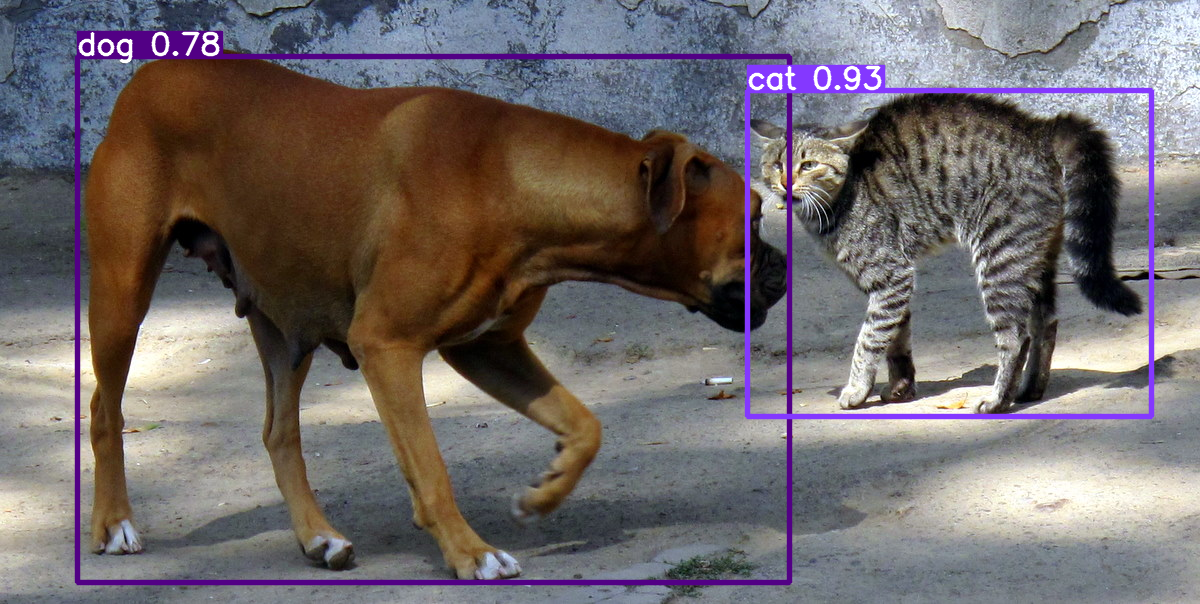

In [ ]:
import torch
from pathlib import Path
from PIL import Image

# Load YOLOv5 model (you may need to adjust the model path)
model_path = 'yolov5s.pt'
model = torch.hub.load('ultralytics/yolov5:master', 'yolov5s')

# Load an input image
image_path = './assets/yolo-input.jpg'
img = Image.open(image_path)

# Perform object detection
results = model(img)

# Print detected classes and confidence scores
#print(results.names)
#print(results.pred[0][:, -1].tolist())  # Confidence scores

# Show the annotated image with bounding boxes
results.show()


## Realtime Object Detection

Let's use YOLO to detect objects in a video.

In [ ]:
!pip install opencv-python

In [ ]:
# use YOLO v5 to detect objects in a video via webcam

import cv2
import torch
from pathlib import Path
from PIL import Image

model_path = 'yolov5s.pt'
model = torch.hub.load('ultralytics/yolov5:master', 'yolov5s')

# use webcam as the video source
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert the frame to a PIL Image
    pil_img = Image.fromarray(frame)

    # Perform object detection
    results = model(pil_img)

    # Print the detected classes and confidence scores
    #print(results.names)
    #print(results.pred[0][:, -1].tolist())  # Confidence scores

    # Show the annotated image with bounding boxes
    results.show()

    # Display the resulting frame
    #cv2.imshow('frame', frame)

    # Press Q on keyboard to  exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    print("continue? [Y/n]")
    if input() == 'n':
        break



# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()